In [30]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

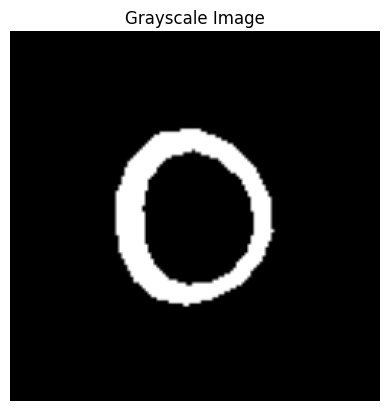

In [31]:
file_path ="data\\anatomicalSegmentations"
img = cv2.imread(file_path+'\\001.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')  # Optional: hides axes
plt.show()

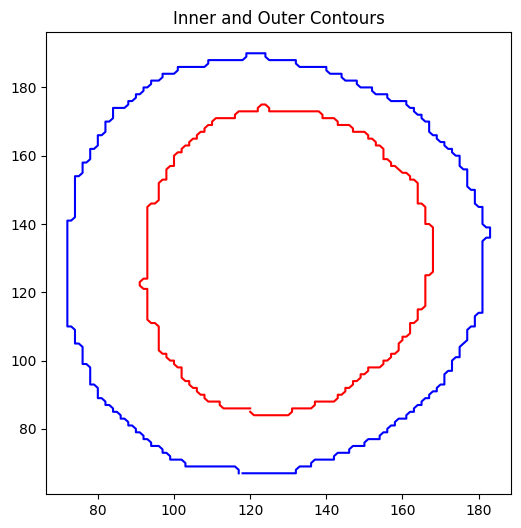

In [32]:
def get_contours(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    outer = contours[0][:, 0, :]  
    inner = contours[1][:, 0, :]  
    return outer, inner

outer,inner = get_contours(file_path+'\\001.png')
plt.figure(figsize=(6, 6))
plt.plot(outer[:, 0], outer[:, 1], label='Outer Contour', color='blue')
plt.plot(inner[:, 0], inner[:, 1], label='Inner Contour', color='red')
plt.title("Inner and Outer Contours")
plt.show()

In [33]:
def simple_resample_contour(contour, num_points=56):
    contour = contour.reshape(-1, 2).astype(np.float32)
    distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
    cumulative = np.insert(np.cumsum(distances), 0, 0)

    total_length = cumulative[-1]
    even_spaced = np.linspace(0, total_length, num_points)

    resampled = []
    for d in even_spaced:
        idx = np.searchsorted(cumulative, d)
        idx = min(idx, len(contour) - 2)
        t = (d - cumulative[idx]) / (cumulative[idx + 1] - cumulative[idx])
        pt = (1 - t) * contour[idx] + t * contour[idx + 1]
        resampled.append(pt)

    return np.array(resampled).T 


In [34]:
resampled_outer = simple_resample_contour(outer, num_points=56)
resampled_inner = simple_resample_contour(inner, num_points=56)

# Combine into a single shape
shape = np.hstack([resampled_outer, resampled_inner])  # shape: (2, 112)

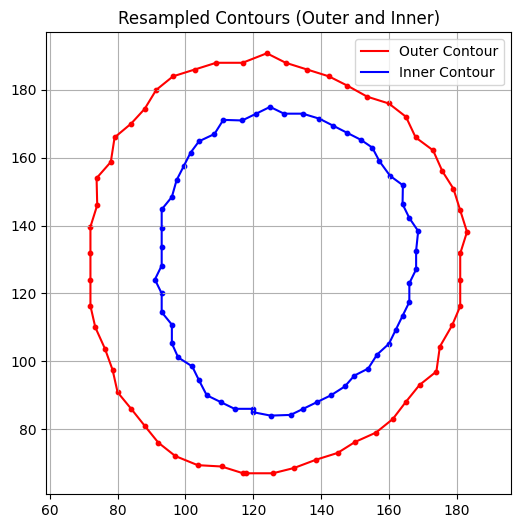

In [35]:
plt.figure(figsize=(6, 6))
plt.plot(resampled_outer[0], resampled_outer[1], 'r-', label='Outer Contour')
plt.plot(resampled_inner[0], resampled_inner[1], 'b-', label='Inner Contour')

# Optional: Add points to highlight samples
plt.scatter(resampled_outer[0], resampled_outer[1], color='red', s=10)
plt.scatter(resampled_inner[0], resampled_inner[1], color='blue', s=10)

plt.axis('equal')
plt.title('Resampled Contours (Outer and Inner)')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
combined_pointsets=[]

for file in os.listdir(file_path):
    if file.endswith(".png"):
        outer, inner = get_contours(os.path.join(file_path, file))
        if outer is not None and inner is not None:
            res_outer = simple_resample_contour(outer)
            res_inner = simple_resample_contour(inner)
        combined = np.hstack([res_outer, res_inner])
        combined_pointsets.append(combined)

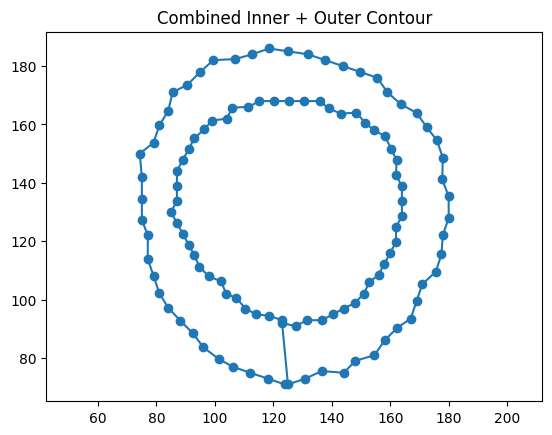

In [38]:
# Plotting the 2D shape of the second shape in combined_pointsets
x = combined_pointsets[1][0]  # x-coordinates
y = combined_pointsets[1][1]  # y-coordinates

plt.plot(x, y, marker='o', linestyle='-')
plt.scatter(x, y, c='red', s=10)
plt.title('Combined Inner + Outer Contour')
plt.axis('equal')  # Ensures aspect ratio is correct
plt.show()


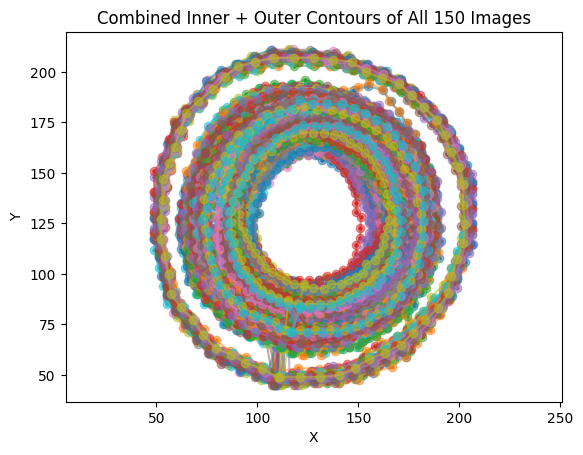

In [39]:
for shape in combined_pointsets:
    x = shape[0]  # x-coordinates
    y = shape[1]  # y-coordinates
    plt.plot(x, y, marker='o', linestyle='-', alpha=0.5)
    plt.scatter(x, y, s=5)

plt.title("Combined Inner + Outer Contours of All 150 Images")
plt.axis('equal')  # Maintain aspect ratio
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [40]:
#Finding the karcher mean__CODE22
def centroid_normalize(shape):
    centered_shape = shape - np.mean(shape, axis=1, keepdims=True)
    norm = np.linalg.norm(centered_shape,'fro')
    normalized_shape = centered_shape / norm if norm != 0 else centered_shape
    # print(normalized_shape.shape)
    return normalized_shape

def best_rotation(A, B):
    # print(B.shape)
    U, S, Vt = np.linalg.svd(B @ A.T)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt
    scale = np.trace(A.T @ R @ B) / np.trace(B.T @ B)
    translation = np.mean(A - scale * R @ B, axis=1, keepdims=True)
    return scale, R, translation

In [41]:
def compute_karcher_mean(pointsets, max_iter=30, tol=1e-6):
    pointsets_array = np.array(pointsets)  # Shape: (n_shapes, 2, 2N)
    n_shape = pointsets_array.shape[0]

    # Normalize each pointset
    for i in range(n_shape):
        pointsets_array[i] = centroid_normalize(pointsets_array[i])

    mean_shape = np.mean(pointsets_array, axis=0)
    mean_shape = centroid_normalize(mean_shape)

    for iter in range(max_iter):
        aligned_shapes = []
        for i in range(n_shape):
            s, R, t = best_rotation(mean_shape, pointsets_array[i])
            aligned = s * R @ pointsets_array[i] + t
            aligned_shapes.append(aligned)

        new_mean = np.mean(np.stack(aligned_shapes), axis=0)
        new_mean = centroid_normalize(new_mean)

        diff = np.linalg.norm(new_mean - mean_shape)
        if diff < tol:
            print(f"Converged in {iter+1} iterations.")
            break
        mean_shape = new_mean

    return mean_shape, aligned_shapes


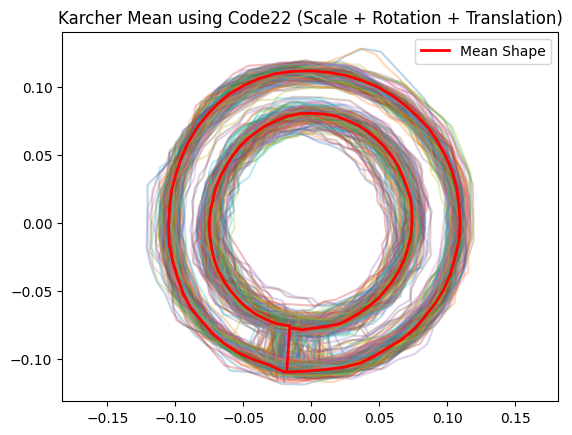

In [42]:
mean_shape_combined, aligned_shapes_code11=compute_karcher_mean(combined_pointsets)

for shape in aligned_shapes_code11:
    plt.plot(shape[0], shape[1], alpha=0.3)

plt.plot(mean_shape_combined[0], mean_shape_combined[1], color='red', linewidth=2, label='Mean Shape')
plt.scatter(mean_shape_combined[0], mean_shape_combined[1], color='red', s=10)
plt.title('Karcher Mean using Code22 (Scale + Rotation + Translation)')
plt.legend()
plt.axis('equal')
plt.show()


In [43]:
def compute_karcher_mean(pointsets, max_iter=30, tol=1e-6):
    pointsets_array = np.array(pointsets)  # Shape: (n_shapes, 2, 56)
    n_shape = pointsets_array.shape[0] # 40
    for i in range(n_shape):
        pointsets_array[i] = centroid_normalize(pointsets_array[i])
    mean_shape = np.mean(pointsets_array, axis=0)
    mean_shape = centroid_normalize(mean_shape)

    for iter in range(max_iter):
        aligned_shapes = []
        for i in range(n_shape):
            s, R,t = best_rotation(mean_shape, pointsets_array[i])
            aligned = s*R @ pointsets_array[i]+t
            aligned_shapes.append(aligned)

        new_mean = np.mean(np.stack(aligned_shapes), axis=0)
        new_mean = centroid_normalize(new_mean)

        diff = np.linalg.norm(new_mean - mean_shape)
        if diff < tol:
            print(f"Converged in {iter+1} iterations.")
            break
        mean_shape = new_mean

    return mean_shape, aligned_shapes

In [44]:
mean_shape_2,aligned_shapes_code22=compute_karcher_mean(outer_pointsets)
for shape in outer_pointsets:
        shape=centroid_normalize(shape)
        plt.plot(shape[0], shape[1], alpha=0.1) 
plt.plot(mean_shape[0], mean_shape[1], color='red', linewidth=2, label='Mean Shape')
plt.scatter(mean_shape[0], mean_shape[1], color='red', s=10)
plt.title('Karcher Mean using Code_22')

NameError: name 'outer_pointsets' is not defined

In [ ]:
def pca_shape_variation(aligned_shapes):
    n_shapes = len(aligned_shapes)
    # Step 1: Flatten each shape to (112,)
    flat_shapes = [shape.flatten() for shape in aligned_shapes]
    data_matrix = np.stack(flat_shapes)  # Shape: (n_shapes, 112)

    # Step 2: Mean shape vector
    mean_vec = np.mean(data_matrix, axis=0)

    # Step 3: Center the data
    centered_data = data_matrix - mean_vec

    # Step 4: Covariance matrix
    cov = np.cov(centered_data, rowvar=False)

    # Step 5: Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    return eigvals, eigvecs


In [ ]:
eigvals11, eigvecs11 = pca_shape_variation(aligned_shapes_code11)
eigvals22, eigvecs22 = pca_shape_variation(aligned_shapes_code22)

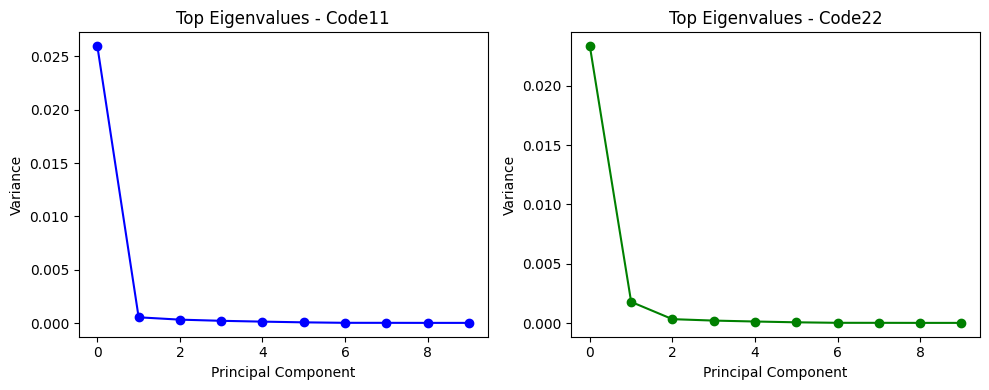

In [ ]:
plt.figure(figsize=(10, 4))

# Code11
plt.subplot(1, 2, 1)
plt.plot(eigvals11[:10], marker='o', color='blue')
plt.title("Top Eigenvalues - Code11")
plt.xlabel("Principal Component")
plt.ylabel("Variance")

# Code22
plt.subplot(1, 2, 2)
plt.plot(eigvals22[:10], marker='o', color='green')
plt.title("Top Eigenvalues - Code22")
plt.xlabel("Principal Component")
plt.ylabel("Variance")

plt.tight_layout()
plt.show()

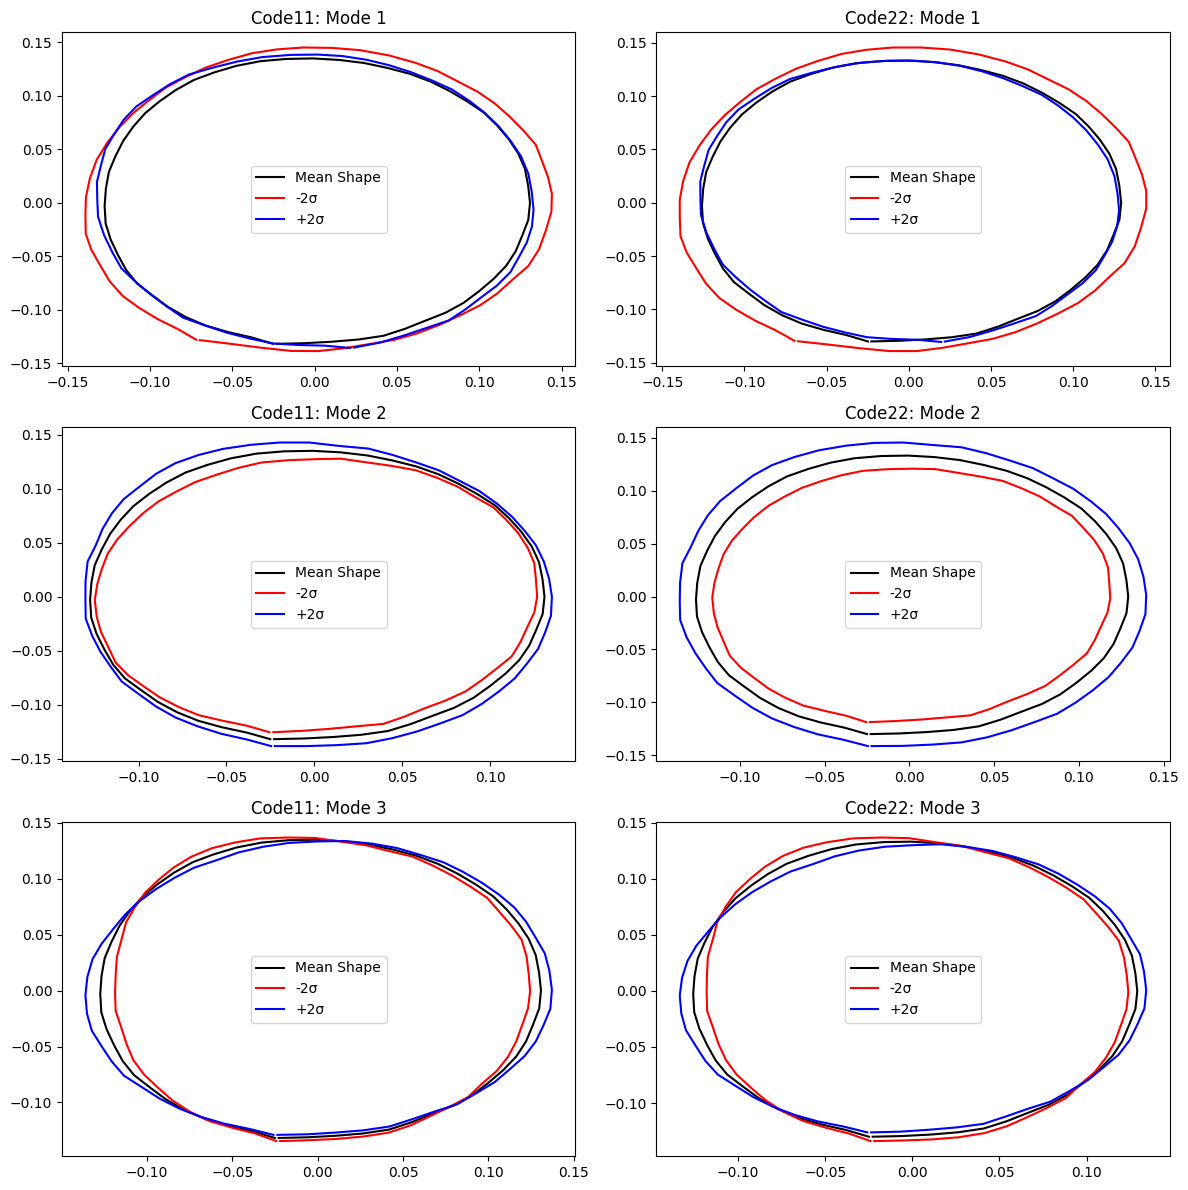

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_shape_covariance(aligned_shapes):
    """
    Compute the shape covariance matrix from aligned pointsets.
    Each shape is flattened into a vector before computing covariance.
    """
    n_shapes = len(aligned_shapes)
    shape_dim = aligned_shapes[0].shape  # (2, 56)
    
    # Flatten each shape into a 1D vector of length (2*56)
    flattened_shapes = np.array([shape.flatten() for shape in aligned_shapes])
    
    # Compute mean and covariance matrix
    mean_vector = np.mean(flattened_shapes, axis=0)
    covariance_matrix = np.cov(flattened_shapes.T)
    
    return mean_vector.reshape(shape_dim), covariance_matrix

def compute_principal_modes(covariance_matrix):
    """
    Perform eigen decomposition of the covariance matrix to get principal modes.
    Returns sorted eigenvalues and corresponding eigenvectors.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    return eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]

def generate_variations(mean_shape, eigenvalues, eigenvectors, std_multipliers=[2, -2]):
    """
    Generate new shapes by perturbing the mean shape along principal modes.
    """
    variations = []
    for mode in range(3):  # Top 3 modes
        mode_vector = eigenvectors[:, mode].reshape(mean_shape.shape)
        for std in std_multipliers:
            variations.append(mean_shape + std * np.sqrt(eigenvalues[mode]) * mode_vector)
    return variations

# Compute covariance and eigen decomposition
mean_shape_code11, covariance_code11 = compute_shape_covariance(aligned_shapes_code11)
mean_shape_code22, covariance_code22 = compute_shape_covariance(aligned_shapes_code22)

eigenvalues_11, eigenvectors_11 = compute_principal_modes(covariance_code11)
eigenvalues_22, eigenvectors_22 = compute_principal_modes(covariance_code22)

# Generate new shapes for visualization
variations_11 = generate_variations(mean_shape_code11, eigenvalues_11, eigenvectors_11, std_multipliers=[-2, 2])
variations_22 = generate_variations(mean_shape_code22, eigenvalues_22, eigenvectors_22, std_multipliers=[-2, 2])

# Plot results
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
titles = ['Code11: Mode 1', 'Code22: Mode 1', 'Code11: Mode 2', 'Code22: Mode 2', 'Code11: Mode 3', 'Code22: Mode 3']

for i in range(3):
    axes[i, 0].plot(mean_shape_code11[0], mean_shape_code11[1], 'k-', label="Mean Shape")
    axes[i, 0].plot(variations_11[2*i][0], variations_11[2*i][1], 'r-', label="-2σ")
    axes[i, 0].plot(variations_11[2*i+1][0], variations_11[2*i+1][1], 'b-', label="+2σ")
    axes[i, 0].set_title(titles[2*i])
    axes[i, 0].legend()
    
    axes[i, 1].plot(mean_shape_code22[0], mean_shape_code22[1], 'k-', label="Mean Shape")
    axes[i, 1].plot(variations_22[2*i][0], variations_22[2*i][1], 'r-', label="-2σ")
    axes[i, 1].plot(variations_22[2*i+1][0], variations_22[2*i+1][1], 'b-', label="+2σ")
    axes[i, 1].set_title(titles[2*i+1])
    axes[i, 1].legend()

plt.tight_layout()
plt.show()
